In [1]:
import numpy as np
import torch

from default_params_multi_item import default_params

import sys
sys.path.append('..')
from rnn.dms_task import DMS
from rnn.utils import *
from rnn.train import *
from rnn.model import RNN

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)

### We first initialize dictionaries to keep track of model, task and training parameters

In [2]:
model_params, training_params, task_params = default_params()

### We can then initialize the task and plot an example trial
Here the network is trained to perform a delayed match to sample task. It recieves four stimuli followed by a short delay and then again the same four stimuli, in the same order as the initial stimulus presentation on half the trials, and on the other half of the trials in a different order.  The network is tasked to give a positive output if the two stimuli sequence orders match and a negative output of the two stimuli sequence orders are different.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


1061 tensor([1.])


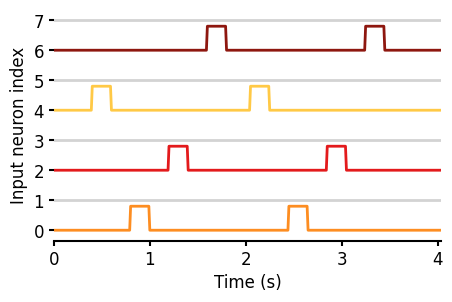

In [3]:
dms = DMS(task_params)    
i = np.random.randint(dms.__len__())
s, t, m = dms[i]
s=s.numpy()
print(i,t[-1])
pltcolors,pltcolors_alt = color_scheme()
dt_sec = 1000/model_params["dt"]
plt_time =  np.arange(0, len(s)) /dt_sec

ci = 0
colors0 = ["lightgray" for _ in range(8)]

t1 = task_params["stim_ons"] - task_params["rand_ons"]
n_channels = task_params["n_channels"]
for i in range(4):
    labels = np.argmax(
        np.sum(s[t1 : t1 + task_params["stim_dur"]], axis=0)
    )
    colors0[labels] = pltcolors[i]
    t1 += task_params["stim_dur"] + task_params["stim_offs"]

for i in np.arange(1, n_channels):
    s[:,i:] += 1.25


with mpl.rc_context(fname="matplotlibrc"):

    fig = plt.figure(figsize=(5, 3))
    gs = fig.add_gridspec(1, 1)  
    axs = fig.add_subplot(gs[0])
    for i in np.arange(n_channels):
        axs.plot(plt_time, s[:,i], color=colors0[i], linewidth=2)
  
    axs.spines["right"].set_visible(False)
    axs.spines["top"].set_visible(False)
    axs.set_xlim(plt_time[0], plt_time[-1])
    axs.set_xlabel("Time (s)")
    axs.spines["left"].set_visible(False)
    axs.set_yticks(np.arange(0, 8 * 1.25, 1.25))
    axs.set_yticklabels(np.arange(8))
    axs.set_ylabel("Input neuron index")
    

### Initialize an RNN and start training it

In [4]:
rnn = RNN(model_params)

losses, reg_losses = train_rnn(rnn, training_params, dms, sync_wandb=False)

spectral_rad: 1.5777704
epoch 50 / 50: time=259.8 s, task loss=0.20677, reg loss=0.00000
Done. Training took 259.8 sec.


### Plot the loss 

Text(0, 0.5, 'loss')

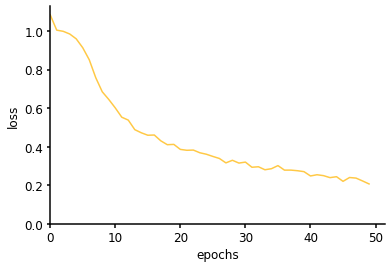

In [5]:
plt.plot(losses)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("epochs")
plt.ylabel("loss")

### Plot the trained weight matrix

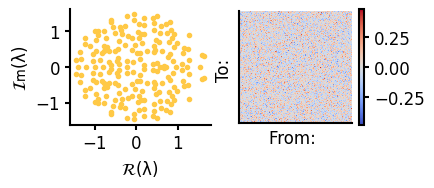

In [6]:
with mpl.rc_context(fname="matplotlibrc"):
    w_eff = rnn.rnn.mask(rnn.rnn.w_rec, rnn.rnn.dale_mask)
    w_eff = w_eff.cpu().detach().numpy()
    eigvals = np.linalg.eigvals(w_eff)
    fig, axs = plt.subplots(1, 2, figsize=(4, 1.5))
    axs[0].scatter(np.real(eigvals), np.imag(eigvals))
    axs[0].set_xlabel(r"$\mathcal{R}(\lambda)$")
    axs[0].set_ylabel(r"$\mathcal{Im}(\lambda)$")
    axs[1].set_ylabel("To: ")
    axs[1].set_xlabel("From: ")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    vmax = np.max(abs(w_eff))
    im = axs[1].imshow(w_eff, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    fig.colorbar(im)

### Plot output for an example match and non match trial


test loss: 0.08227391541004181
test loss: 0.05308932065963745


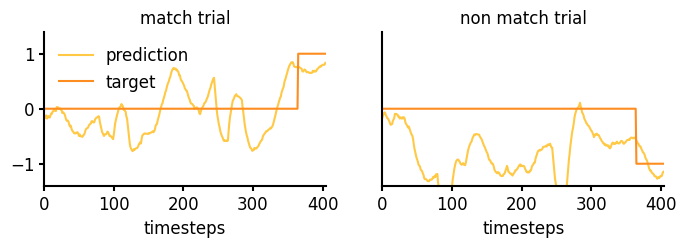

In [7]:
dms = DMS(task_params)    
s, t, m = dms[0]
rates, pred = predict(rnn, s, mse_loss, t, m)
sn, tn, mn = dms[dms.__len__()-1]
ratesn, predn = predict(rnn, sn, mse_loss, tn, mn)


with mpl.rc_context(fname="matplotlibrc"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].set_title("match trial")
    axs[0].plot(pred[0], label="prediction")
    axs[0].plot(t, label="target")
    axs[0].set_ylim(-1.4, 1.4)
    axs[0].legend()
    axs[0].set_xlim(0, dms.trial_len())
    axs[0].set_xlabel("timesteps")
    axs[1].set_title("non match trial")
    axs[1].set_yticks([])
    axs[1].plot(predn[0], label="prediction")
    axs[1].plot(tn, label="target")
    axs[1].set_ylim(-1.4, 1.4)
    axs[1].set_xlabel("timesteps")
    axs[1].set_xlim(0, dms.trial_len())

### Save and load a model
We plot the output for the previous two trials to check the loaded model

spectral_rad: 1.5184385
test loss: 0.02491532638669014
test loss: 0.12967732548713684


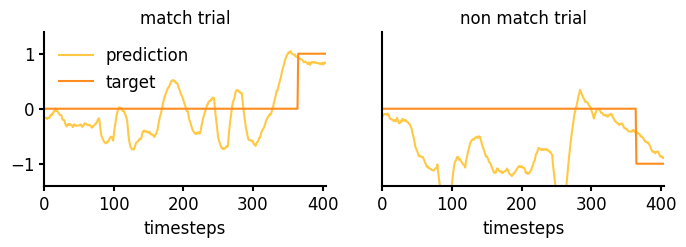

In [8]:
# save and load
save_rnn("test_model", rnn, model_params, task_params, training_params)
rnn2, model_params, task_params, training_params = load_rnn("test_model")

# plot example output of new net
rates, pred = predict(rnn2, s, mse_loss, t, m)
ratesn, predn = predict(rnn2, sn, mse_loss, tn, mn)


with mpl.rc_context(fname="matplotlibrc"):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))
    axs[0].set_title("match trial")
    axs[0].plot(pred[0], label="prediction")
    axs[0].plot(t, label="target")
    axs[0].set_ylim(-1.4, 1.4)
    axs[0].legend()
    axs[0].set_xlim(0, dms.trial_len())
    axs[0].set_xlabel("timesteps")
    axs[1].set_title("non match trial")
    axs[1].set_yticks([])
    axs[1].plot(predn[0], label="prediction")
    axs[1].plot(tn, label="target")
    axs[1].set_ylim(-1.4, 1.4)
    axs[1].set_xlabel("timesteps")
    axs[1].set_xlim(0, dms.trial_len())